In [186]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from scipy.optimize import minimize
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
import scipy.stats as sps

myparams = {
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}',
    'font.family': 'Djvu Serif',
    'font.size': 14,
    'axes.grid': True,
    'grid.alpha': 0.1,
    'lines.linewidth': 2
}

plt.rcParams.update(myparams)

from utils import Dataset
from models import RegressionModel, LogisticModel

%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Линейная регрессия

$$ \mathbf{X} \in \mathbb{R}^{m \times n}, \qquad \mathbf{y} \in \mathbb{R}^{m}, \qquad \mathbf{w} \in \mathbb{R}^{n} $$

$$ p(\mathbf{y}, \mathbf{w}, \mathbf{X} | \alpha) = \prod_{i=1}^{m} \mathcal{N}(\mathbf{x}_i | \boldsymbol{\mu}, \mathbf{\Sigma}) \mathcal{N}(\mathbf{w} | \mathbf{0}, \alpha^{-1} \mathbf{I}_n) \prod_{i=1}^{m} p(y_i | \mathbf{x}_i, \mathbf{w}) $$

$$ p(y_i | \mathbf{x}_i, \mathbf{w}) = \mathcal{N}(y_i | \mathbf{w}^\top \mathbf{x}_i,  \sigma^2) $$

In [180]:
m = 1000
n = 20

mu = np.zeros(n)
Sigma = np.identity(n)

alpha = 1
sigma2 = 1

In [181]:
X = sps.multivariate_normal(mean=mu, cov=Sigma).rvs(size=m)
w = sps.multivariate_normal(mean=np.zeros(n), cov=alpha**(-1)*np.identity(n)).rvs(size=1)
eps = sps.multivariate_normal(mean=np.zeros(m), cov=sigma2*np.identity(m)).rvs(size=1)
y = X @ w + eps

In [182]:
dataset = Dataset(X, y)

## Оптимальный объем выборки в терминах дисперсии правдоподобия

### Оптимальный объем выборки не превосходит доступный

In [183]:
sample_sizes = np.arange(2*n, X.shape[0], 10)+1

In [184]:
B = 1000
llh_means = []
llh_stds = []
loss_means = []
loss_stds = []

for m in tqdm(sample_sizes):
    tmp = []
    tmp_loss = []
    for _ in range(B):
        X_m, y_m = Dataset(X, y).sample(m)
        model = RegressionModel(X_m, y_m)
        w_hat = model.fit()
        tmp.append(model.loglikelihood(params=w_hat))
        tmp_loss.append(model.loss(params=w_hat))
    tmp = np.array(tmp)
    tmp_loss = np.array(tmp_loss)
    llh_means.append(tmp.mean())
    llh_stds.append(tmp.std())
    loss_means.append(tmp_loss.mean())
    loss_stds.append(tmp_loss.std())

llh_means = np.array(llh_means)
llh_stds = np.array(llh_stds)
loss_means = np.array(loss_means)
loss_stds = np.array(loss_stds)

100%|██████████| 96/96 [00:37<00:00,  2.53it/s]


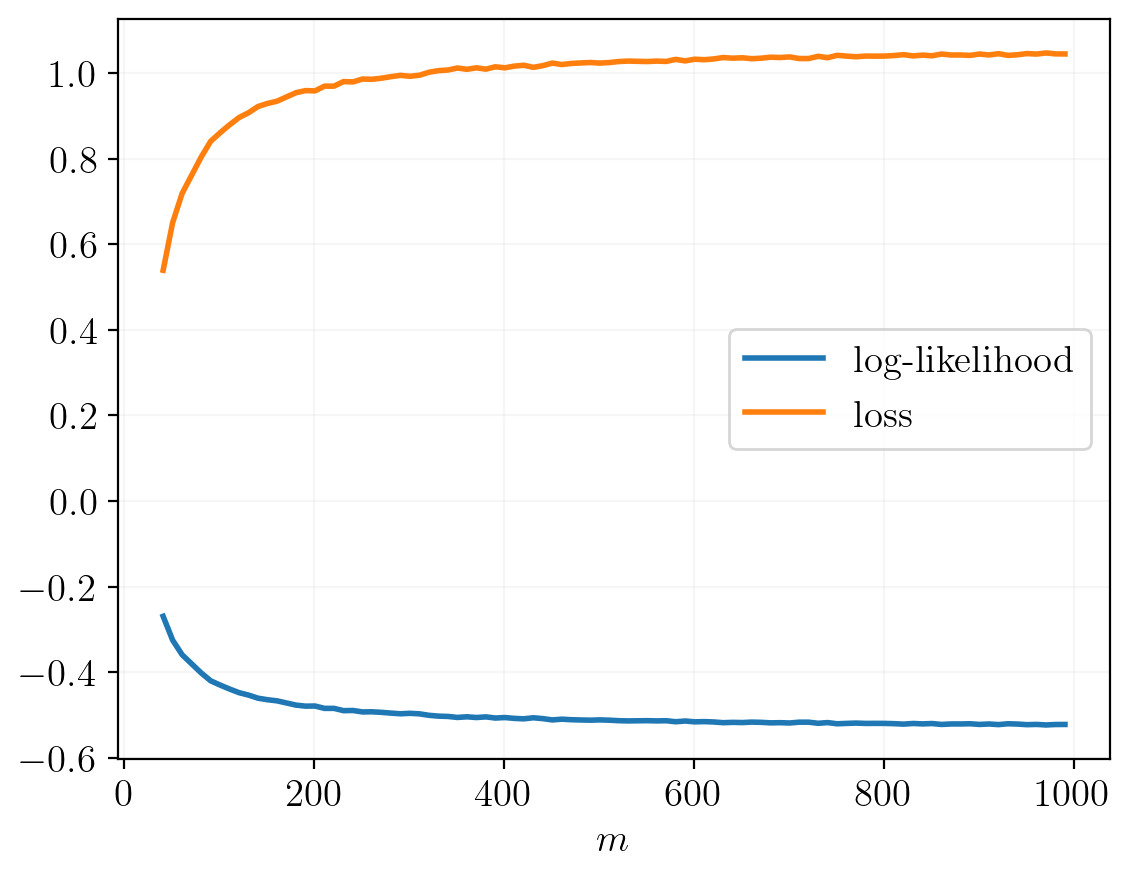

In [188]:
plt.plot(sample_sizes, llh_means, label='log-likelihood')
#plt.fill_between(sample_sizes, llh_means - llh_stds, llh_means + llh_stds, alpha=0.3)
plt.plot(sample_sizes, loss_means, label="loss")
#plt.plot(sample_sizes, np.exp(-loss_means), label=r"$\exp(-\mathrm{loss})$")
#plt.fill_between(sample_sizes, loss_means - loss_stds, loss_means + loss_stds, alpha=0.3)

plt.legend()
plt.xlabel(r"$m$")
#plt.xlim(0, 200)
#plt.ylabel(r"$l(D_m)$")
plt.show()

## Оптимальный объем выборки в терминах изменения правдоподобия

### Оптимальный объем выборки не превосходит доступный

# Diabetes

In [189]:
loading = pickle.load(open("datasets/diabetes5000.p", "rb"))

ordering = loading[0] # features numbers in order of their informativeness
sample_sizes = loading[1] # np.array of size 350 with different sample sizes
means = loading[2] # list of log-likelihood (or -loss) means for sample sizes in SampleStep for different number of features (from 1 to 10)
stds = loading[3] # list of log-likelihood (or -loss) stds for sample sizes in SampleStep for different number of features (from 1 to 10)
X_train = loading[4] # np.array of shape(361, 10) with training data
y_train = loading[5] # np.array of size 361 with training target
X_test = loading[6] # np.array of shape(81, 10) with testing data
y_test = loading[7] # np.array of size 81 with testing target

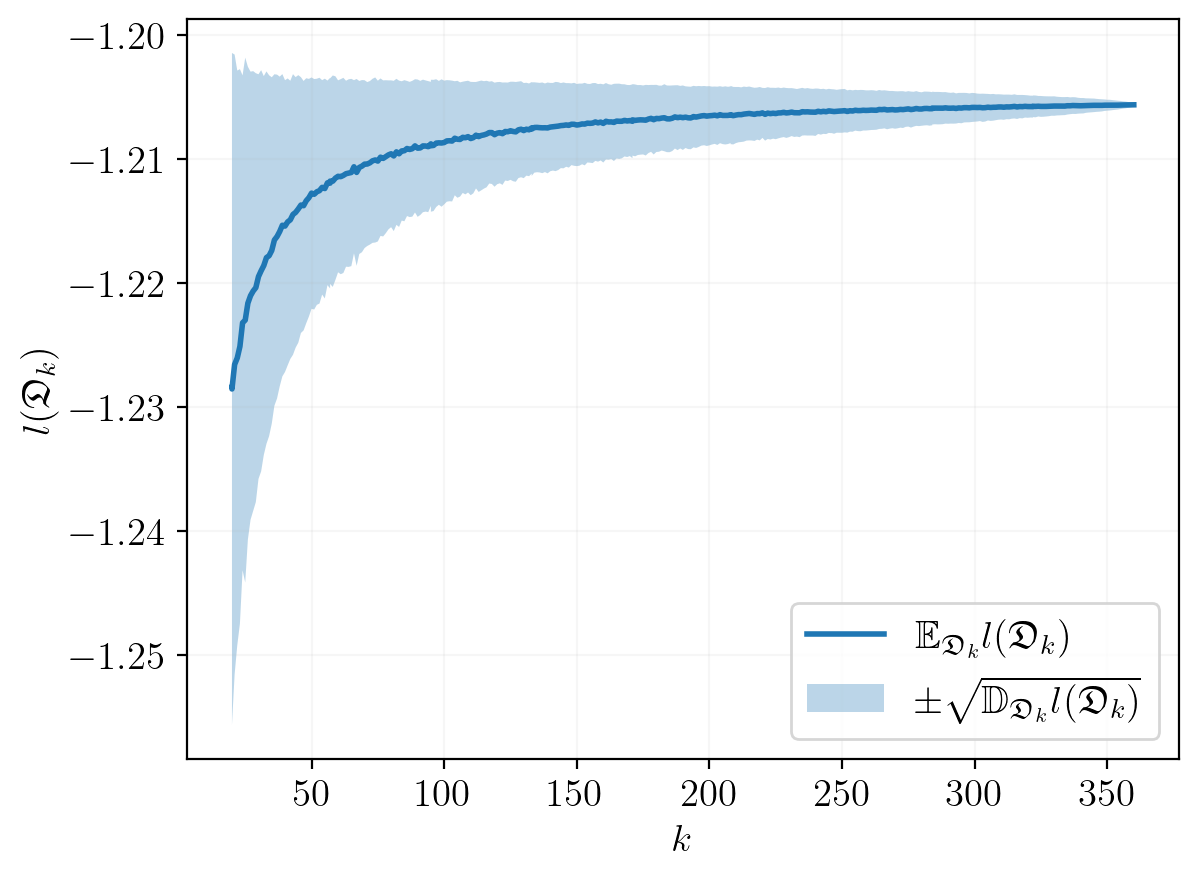

In [241]:
#N = 0 # number of features = 1
N = 8 # number of features = 9

means[N] = np.array(means[N])
stds[N] = np.array(stds[N])

plt.plot(sample_sizes, means[N], label=r"$\mathbb{E}_{\mathfrak{D}_k} l(\mathfrak{D}_k)$")
plt.fill_between(sample_sizes, means[N] - stds[N], means[N] + stds[N], alpha=0.3, label=r"$\pm \sqrt{\mathbb{D}_{\mathfrak{D}_k} l(\mathfrak{D}_k)}$")
plt.legend(loc='lower right')

plt.xlabel(r"$k$")
plt.ylabel(r"$l(\mathfrak{D}_k)$")

plt.show()

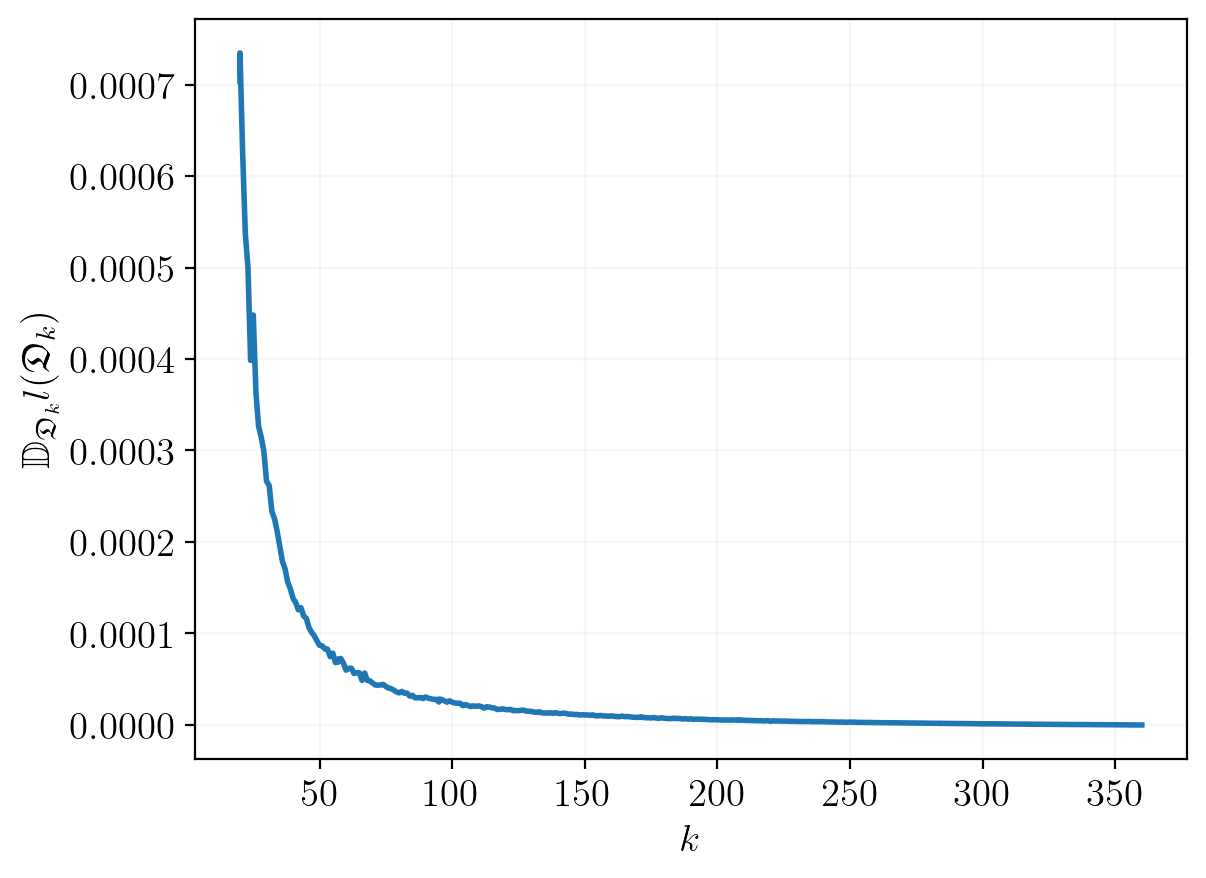

In [242]:
plt.plot(sample_sizes, stds[N]**2)

plt.xlabel(r"$k$")
plt.ylabel(r"$\mathbb{D}_{\mathfrak{D}_k} l(\mathfrak{D}_k)$")
#plt.yscale('log')

plt.show()

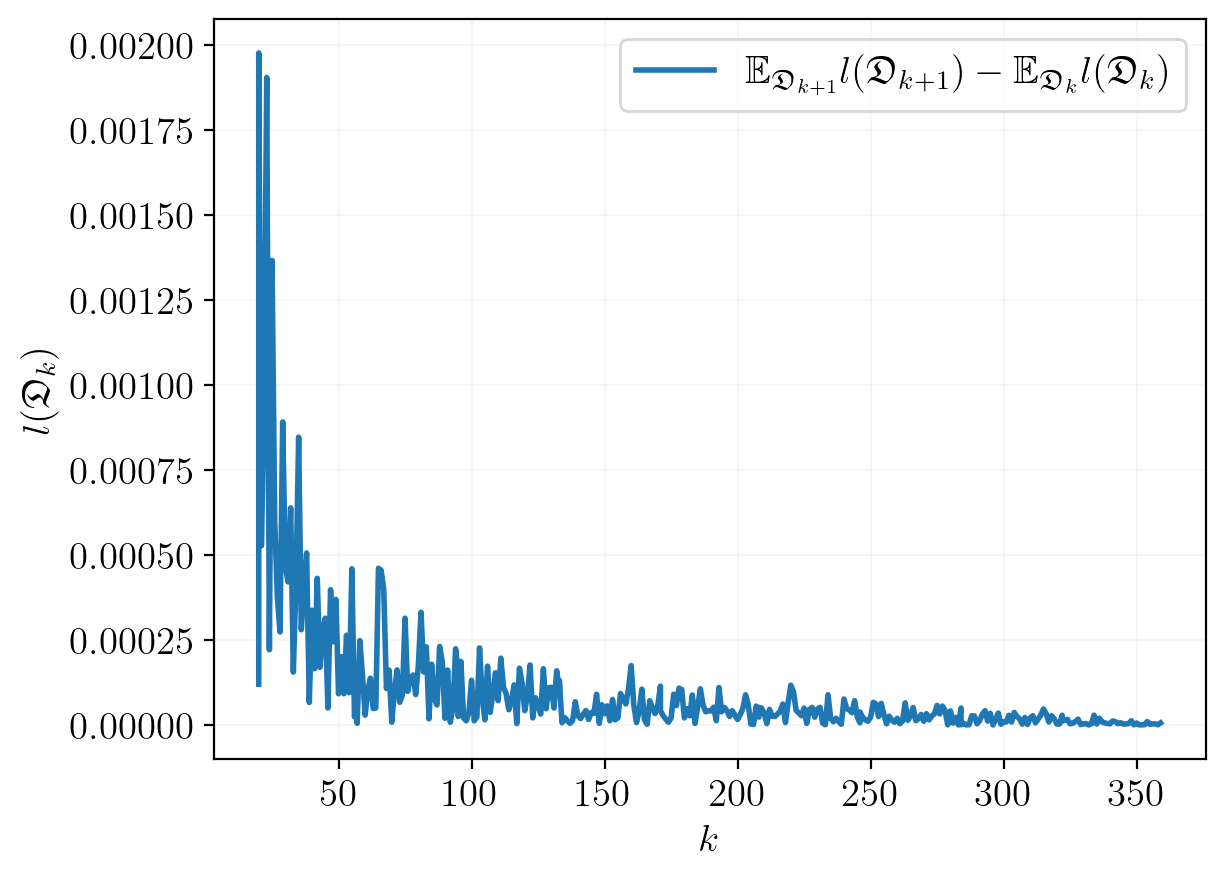

In [259]:
#N = 0 # number of features = 1
N = 8 # number of features = 9

means[N] = np.array(means[N])
stds[N] = np.array(stds[N])

plt.plot(sample_sizes[:-1], np.abs(np.diff(means[N], n=1)), label=r"$\mathbb{E}_{\mathfrak{D}_{k+1}} l(\mathfrak{D}_{k+1}) - \mathbb{E}_{\mathfrak{D}_k} l(\mathfrak{D}_k)$")
#plt.vlines(m_star, min(means[N] - stds[N]), means[N][m_star], colors='red', linestyle='dashed', linewidth=1, label=f"$m^*={m_star}$")
#plt.scatter(m_star, means[N][m_star], marker='o', color='red')
plt.legend(loc='upper right')

plt.xlabel(r"$k$")
plt.ylabel(r"$l(\mathfrak{D}_k)$")
#plt.yscale('log')

plt.show()

## Оптимальный объем выборки в терминах дисперсии правдоподобия

### Оптимальный объем выборки не превосходит доступный

In [303]:
def opt_sample_size(sample_sizes, means, stds, eps=1e-4, method="variance"):
    
    m_star = np.inf
    
    if method == "variance":
        for k, var in zip(sample_sizes, stds**2):
            if var <= eps and m_star == np.inf:
                m_star = k
            elif var > eps:
                m_star = np.inf
                
    elif method == "rate":
        for k, diff in zip(sample_sizes[:-1], np.abs(np.diff(means, n=1))):
            if diff <= eps and m_star == np.inf:
                m_star = k
            elif diff > eps:
                m_star = np.inf
        
    return m_star

Возьмем $\varepsilon = 10^{-5}$

In [304]:
m_star = opt_sample_size(sample_sizes, means[N], stds[N], eps=1e-5, method="variance")
print(f"m* = {m_star}")

m* = 157


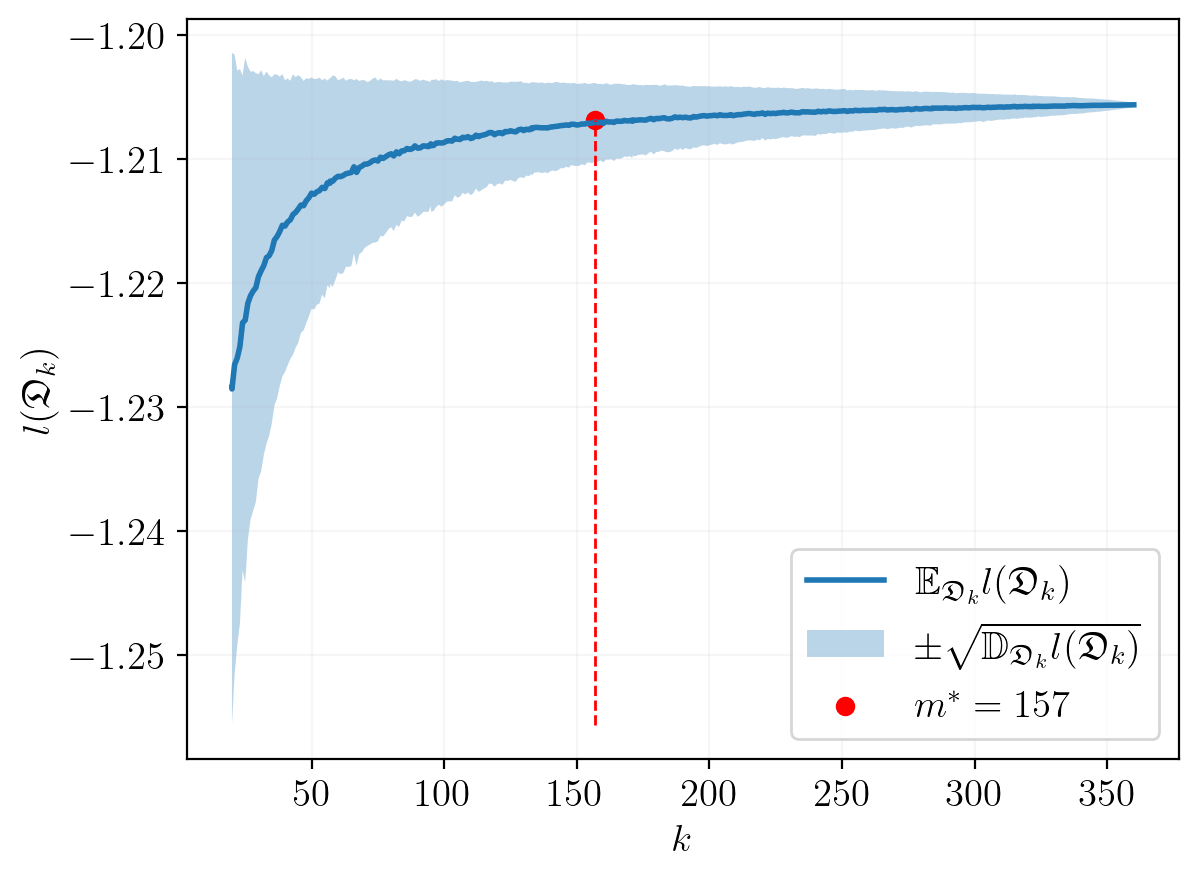

In [305]:
#N = 0 # number of features = 1
N = 8 # number of features = 9

means[N] = np.array(means[N])
stds[N] = np.array(stds[N])

plt.plot(sample_sizes, means[N], label=r"$\mathbb{E}_{\mathfrak{D}_k} l(\mathfrak{D}_k)$")
plt.fill_between(sample_sizes, means[N] - stds[N], means[N] + stds[N], alpha=0.3, label=r"$\pm \sqrt{\mathbb{D}_{\mathfrak{D}_k} l(\mathfrak{D}_k)}$")
plt.vlines(m_star, min(means[N] - stds[N]), means[N][m_star], colors='red', linestyle='dashed', linewidth=1)
plt.scatter(m_star, means[N][m_star], marker='o', color='red', label=f"$m^*={m_star}$")
plt.legend(loc='lower right')

plt.xlabel(r"$k$")
plt.ylabel(r"$l(\mathfrak{D}_k)$")

plt.savefig("diabetes-variance-criterion.pdf", bbox_inches='tight')

plt.show()

## Оптимальный объем выборки в терминах изменения правдоподобия

### Оптимальный объем выборки не превосходит доступный

Возьмем $\varepsilon = 10^{-4}$

In [306]:
m_star = opt_sample_size(sample_sizes, means[N], stds[N], eps=1e-4, method="rate")
print(f"m* = {m_star}")

m* = 221


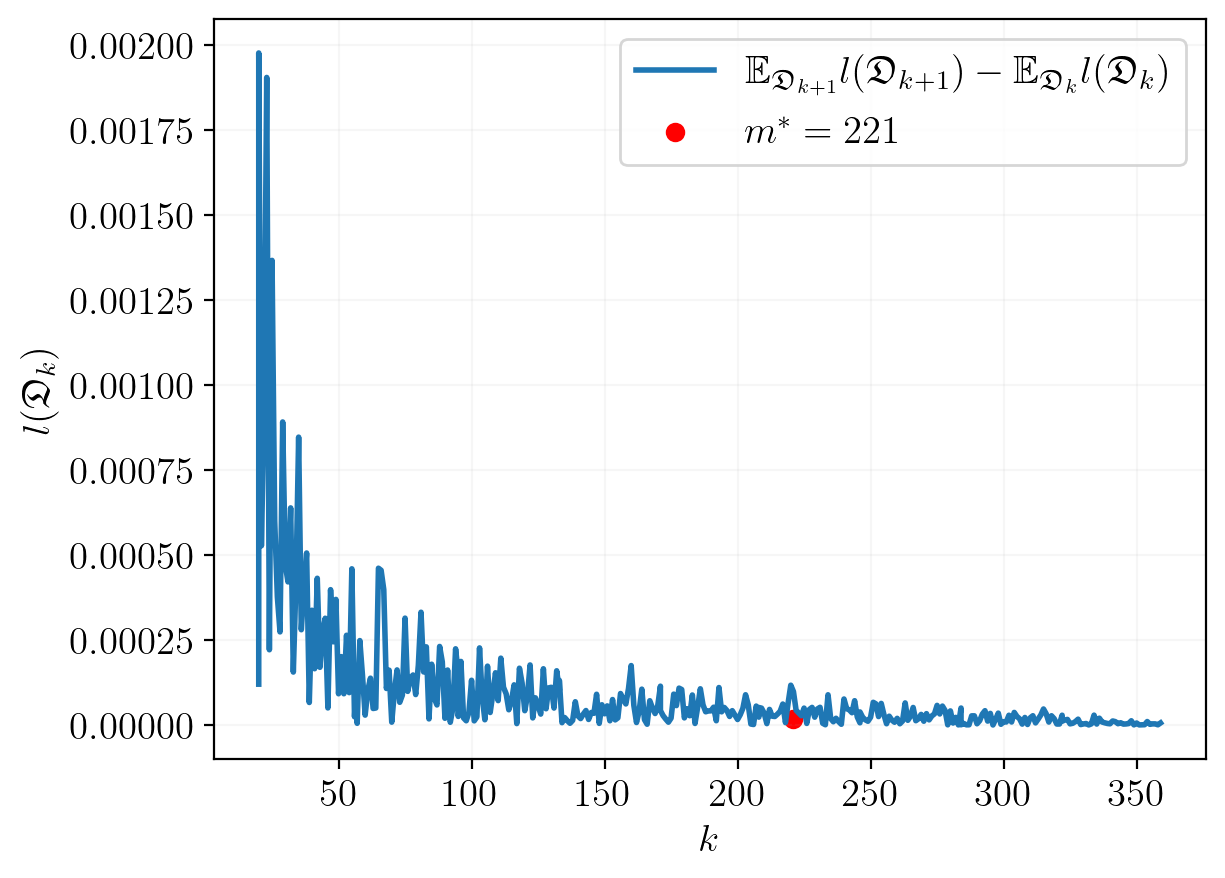

In [307]:
#N = 0 # number of features = 1
N = 8 # number of features = 9

means[N] = np.array(means[N])
stds[N] = np.array(stds[N])

plt.plot(sample_sizes[:-1], np.abs(np.diff(means[N], n=1)), label=r"$\mathbb{E}_{\mathfrak{D}_{k+1}} l(\mathfrak{D}_{k+1}) - \mathbb{E}_{\mathfrak{D}_k} l(\mathfrak{D}_k)$")
plt.vlines(m_star, min(np.abs(np.diff(means[N], n=1))), np.abs(np.diff(means[N], n=1))[m_star], colors='red', linestyle='dashed', linewidth=1)
plt.scatter(m_star, np.abs(np.diff(means[N], n=1))[m_star], marker='o', color='red', label=f"$m^*={m_star}$")
plt.legend(loc='upper right')

plt.xlabel(r"$k$")
plt.ylabel(r"$l(\mathfrak{D}_k)$")

plt.savefig("diabetes-rate-criterion.pdf", bbox_inches='tight')

plt.show()